
=== Round Robin ===


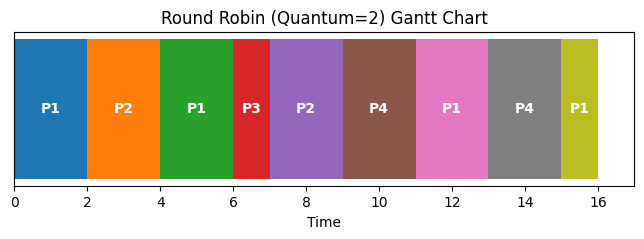

,PID,AT,BT,ST,CT,TAT,WT
0,P1,0,7,0,16,16,9
1,P2,2,4,2,9,7,3
2,P3,4,1,6,7,3,2
3,P4,5,4,9,15,10,6


Average Turnaround Time = 9.00
Average Waiting Time   = 5.00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Process:
    pid: str
    arrival: int
    burst: int
    start: int = None
    completion: int = None
    tat: int = None
    wt: int = None

# ---------- Metrics + Table ----------

def calculate_metrics(processes: List[Process], timeline: List[Tuple[str, int, int]]):
    for p in processes:
        # Find the first start and last completion for each process
        starts = [s for pid, s, e in timeline if pid == p.pid]
        ends = [e for pid, s, e in timeline if pid == p.pid]
        if starts:
            p.start = starts[0]
            p.completion = ends[-1]
            p.tat = p.completion - p.arrival
            p.wt = p.tat - p.burst
        else:
            p.start = p.completion = p.tat = p.wt = None

    df = pd.DataFrame([{
        "PID": p.pid,
        "AT": p.arrival,
        "BT": p.burst,
        "ST": p.start,
        "CT": p.completion,
        "TAT": p.tat,
        "WT": p.wt
    } for p in processes])

    avg_tat = df["TAT"].mean()
    avg_wt = df["WT"].mean()

    display(df)  # nice Jupyter table
    print(f"Average Turnaround Time = {avg_tat:.2f}")
    print(f"Average Waiting Time   = {avg_wt:.2f}")

# ---------- Gantt Chart ----------

def draw_gantt_chart(timeline: List[Tuple[str, int, int]], title: str):
    fig, ax = plt.subplots(figsize=(8,2))
    for i, (pid, start, end) in enumerate(timeline):
        ax.barh(0, end-start, left=start, height=0.3, align='center')
        ax.text((start+end)/2, 0, pid, ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    ax.set_yticks([])
    ax.set_xlim(0, max(end for _,_,end in timeline)+1)
    ax.set_xlabel("Time")
    ax.set_title(title)
    plt.show()

# ---------- Round Robin Scheduling Algorithm ----------

def round_robin(processes: List[Process], quantum: int):
    n = len(processes)
    procs = sorted(processes, key=lambda p: (p.arrival, p.pid))
    ready_queue = []
    t = 0
    timeline = []
    remaining = {p.pid: p.burst for p in procs}
    arrived = set()
    last_executed = {}

    while len(arrived) < n or ready_queue:
        # Add newly arrived processes to the queue
        for p in procs:
            if p.arrival <= t and p.pid not in arrived:
                ready_queue.append(p)
                arrived.add(p.pid)

        if not ready_queue:
            # If no process is ready, jump to next arrival
            next_arrival = min([p.arrival for p in procs if p.pid not in arrived], default=None)
            if next_arrival is not None:
                t = next_arrival
                continue
            else:
                break

        p = ready_queue.pop(0)
        start = t
        exec_time = min(quantum, remaining[p.pid])
        t += exec_time
        end = t
        timeline.append((p.pid, start, end))
        remaining[p.pid] -= exec_time

        # Add any new arrivals during this quantum
        for q in procs:
            if q.arrival > start and q.arrival <= t and q.pid not in arrived:
                ready_queue.append(q)
                arrived.add(q.pid)

        if remaining[p.pid] > 0:
            ready_queue.append(p)

    print("\n=== Round Robin ===")
    draw_gantt_chart(timeline, f"Round Robin (Quantum={quantum}) Gantt Chart")
    calculate_metrics(procs, timeline)

# ---------- Example Run ----------

processes = [
    Process("P1", 0, 7),
    Process("P2", 2, 4),
    Process("P3", 4, 1),
    Process("P4", 5, 4),
]

round_robin([Process(p.pid, p.arrival, p.burst) for p in processes], quantum=2)